Part A: Gaussian Generative Classifier for Handwritten Digits

# Introduction and Overview
## Goal
We aim to classify handwritten digits (0–9) from the sklearn `load_digits()` dataset using a **Gaussian Generative Classifier**.

## Idea
A generative classifier models the joint distribution p(x, y) and predicts a class y given an input x using Bayes' theorem:

p(y | x) ∝ p(x | y) * p(y)
## Assumptions
- Each class k (digit 0–9) is generated from a **multivariate Gaussian distribution**:

p(x | y = k) = N(x; μ_k, Σ)

where μ_k is the mean vector of class k, and Σ is a **shared covariance matrix** for all classes.  

- Class priors are estimated from the training data:
pi_k = (number of samples in class k) / (total number of samples)

## Steps in this part
1. Load and split the digits dataset into **train / validation / test** sets.  
2. Standardize features to **zero mean and unit variance**.  
3. Implement a **Gaussian Generative Classifier** from scratch.  
4. Tune the **covariance regularization hyperparameter λ** using the validation set.  
5. Train the final model on **train + validation**, evaluate on the **test set**, and report:  
   - Test accuracy  
   - Macro precision, recall, F1-score  
   - Confusion matrix  
   - Per-class accuracy, precision, recall, F1-score  
   - Visualization of learned class means


Import Libraries

In [1]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


Load Dataset

Each sample is an 8×8 grayscale image flattened into a 64-dimensional vector.
There are 10 classes, corresponding to digits 0–9

In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data     # shape: (1797, 64)
y = digits.target   # labels: 0–9
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Dataset shape: (1797, 64), Labels shape: (1797,)


Data splitting 70% Train, 15% Val, 15% Test

In [3]:
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,              # keep 30% for {validation + test}
    stratify=y,
    random_state=42
)
# Second split: Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)


Train: (1257, 64) Validation: (270, 64) Test: (270, 64)


Feature Scaling

Standardizing features ensures all 64 pixel values have zero mean and unit variance, which is important for numerical stability in Gaussian calculations.

In [4]:
# Feature Scaling
# Standardize features by removing the mean and scaling to unit variance
print("Before scaling:")
print("Mean (train):", X_train.mean(), "Std:", X_train.std())
print("Mean (val):", X_val.mean(), "Std:", X_val.std())
print("Mean (test):", X_test.mean(), "Std:", X_test.std())
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test) 
print("After scaling:")
print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)
print("Mean (train):", X_train.mean(), "Std:", X_train.std())
print("Mean (val):", X_val.mean(), "Std:", X_val.std())
print("Mean (test):", X_test.mean(), "Std:", X_test.std())

Before scaling:
Mean (train): 4.886858591885441 Std: 6.014331889996329
Mean (val): 4.913657407407407 Std: 6.024617596074179
Mean (test): 4.842129629629629 Std: 6.020159658724134
After scaling:
Train: (1257, 64) Validation: (270, 64) Test: (270, 64)
Mean (train): 7.99325248437364e-18 Std: 0.9682458365518539
Mean (val): 0.02168005304607221 Std: 1.1466034506653613
Mean (test): -0.01574836964443066 Std: 0.9237565889728525


# Gaussian Generative Classifier Implementation

## Mathematical Idea

### Class Priors
π_k = P(y = k)  
The prior probability of class k is estimated as the fraction of training samples belonging to class k.

### Class Means
μ_k = average of all samples with label k  
Each class has a mean vector computed by averaging all training samples in that class.

### Shared Covariance
Σ = (1 / N) * Σ_{i=1}^N (x_i - μ_{y_i}) (x_i - μ_{y_i})^T  
The shared covariance matrix is computed using all samples across classes. It captures how features vary jointly across the dataset.

### Regularization
Σ_λ = Σ + λ * I  
A small regularization term λ is added to the diagonal to ensure that Σ is positive definite and invertible.

### Prediction Rule
ŷ = argmax_k [ log(π_k) + log N(x; μ_k, Σ_λ) ]  
For a new input x, compute a score for each class k using the log prior and log Gaussian likelihood. Predict the class with the highest score.

In [5]:
class GaussianGenerativeClassifier:
    def __init__(self, lambda_reg=1e-3):
        self.lambda_reg = lambda_reg   
        self.priors = None #pi_k size (K,)
        self.means = None #mu_k size (K, D)
        self.cov = None #shared covariance size (D, D)
        self.cov_reg = None #regularized covariance size (D, D)
        self.inv_cov = None #inverse covariance size (D, D)
        self.classes = None  # unique class labels size (K,)
        self.logdet = None # log determinant of covariance 
        self.d = None # feature dimension size (D,)

    #        TRAINING (FIT)
   
    def fit(self, X, y):
        """
        X: (N, D) training data
        y: (N,) training labels
        """
        N, D = X.shape
        self.d = D
        self.classes= np.unique(y)
        K = len(self.classes)
        
        # 1. Priors pi_k
        self.priors = np.zeros(K)
        for idx, k in enumerate(self.classes):
            self.priors[idx] = np.mean(y == k)

        # 2. Class means mu_k
        self.means = np.zeros((K, D))
        for idx, k in enumerate(self.classes):
            self.means[idx] = X[y == k].mean(axis=0)

        # 3. Shared covariance 
        cov = np.zeros((D, D))
        diffs = X - self.means[y]
        cov = diffs.T @ diffs / N
        cov += self.lambda_reg * np.eye(D)

        """
        for idx, k in enumerate(self.classes):
            Xk = X[y == k]
            diffs = Xk - self.means[idx]
            cov += diffs.T @ diffs

        """
        #cov /= N

        # 4. Regularization Σ_λ = Σ + λI
        #cov += self.lambda_reg * np.eye(D)
        
        self.cov = cov
        self.cov_inv = np.linalg.inv(cov)
        sign,logdet = np.linalg.slogdet(cov) 
        if sign <= 0:
            raise ValueError("Regularized covariance is not positive definite.")
        self.cov_logdet = logdet

    #        PREDICT LOG SCORES
    def log_gaussian(self, x, mean):
        """
        Compute log N(x; mean, cov)
        Using multivariate Gaussian log-likelihood.
        """
        D = len(x)
        diff = x - mean
        return -0.5 * (
            diff @ self.cov_inv @ diff
            + self.cov_logdet
            + D * np.log(2 * np.pi)
        )

    #       PREDICT CLASS
    def predict(self, X):
        y_pred = []
        for x in X:
            scores = []
            for k_idx, k in enumerate(self.classes):
                log_prior = np.log(self.priors[k_idx])
                log_likelihood = self.log_gaussian(x, self.means[k_idx])
                scores.append(log_prior + log_likelihood)

            y_pred.append(self.classes[np.argmax(scores)])
        return np.array(y_pred)
    
    
    def predict_proba(self, X):
        """
        Predict class probabilities using softmax over log-scores.
        """
        N = X.shape[0]
        K = len(self.classes)
        probs = np.zeros((N, K))
        for i, x in enumerate(X):
            log_scores = np.zeros(K)
            for idx in range(K):
                log_scores[idx] = np.log(self.priors[idx]) + self.log_gaussian(x, self.means_[idx])
            # softmax
            exp_scores = np.exp(log_scores - np.max(log_scores))
            probs[i] = exp_scores / np.sum(exp_scores)
        return probs

    #       CLASSIFICATION ACCURACY
    def score(self, X, y):
        """
        Compute accuracy of the classifier.
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [6]:
# train using your chosen lambda, e.g. 1e-3
model = GaussianGenerativeClassifier(lambda_reg=1e-3)
model.fit(X_train, y_train)

# Predictions
y_val_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))


Validation Accuracy: 0.9444444444444444


Hyperparameter Tuning (λ Regularization)

In [7]:
lambdas = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2,0.1,1,10]
best_acc = 0
best_lambda = None
val_results = []
train_results = []
for lam in lambdas:
    model = GaussianGenerativeClassifier(lambda_reg=lam)
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    train_results.append(train_acc)

    
    y_val_predict = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_predict)
    val_results.append((val_acc))
    print(f"λ = {lam:.0e}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    if val_acc >= best_acc:
        best_acc = val_acc
        best_lambda = lam

print("Best Lamda =", best_lambda)


λ = 1e-08, Train Acc = 0.9690, Val Acc = 0.9444
λ = 1e-07, Train Acc = 0.9690, Val Acc = 0.9444
λ = 1e-06, Train Acc = 0.9690, Val Acc = 0.9444
λ = 1e-05, Train Acc = 0.9690, Val Acc = 0.9444
λ = 1e-04, Train Acc = 0.9690, Val Acc = 0.9444
λ = 1e-03, Train Acc = 0.9690, Val Acc = 0.9444
λ = 1e-02, Train Acc = 0.9682, Val Acc = 0.9444
λ = 1e-01, Train Acc = 0.9642, Val Acc = 0.9444
λ = 1e+00, Train Acc = 0.9475, Val Acc = 0.9222
λ = 1e+01, Train Acc = 0.9125, Val Acc = 0.8481
Best Lamda = 0.1


Plot train vs validation accuracies for lambda

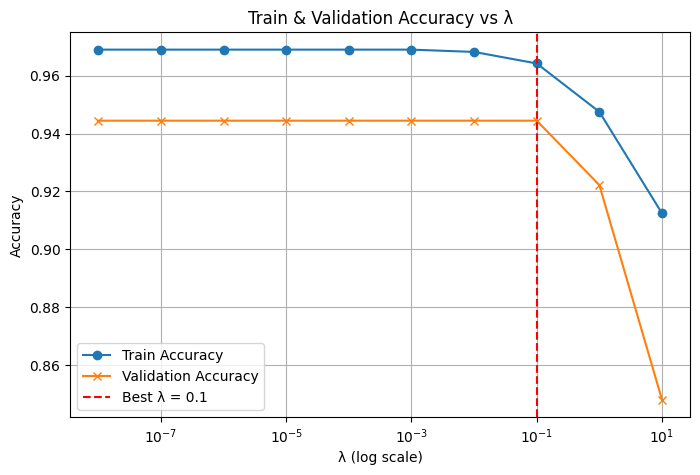

In [8]:
# Plotting Train and Validation Accuracy vs Lambda
plt.figure(figsize=(8,5))
plt.semilogx(lambdas, train_results, marker='o', label='Train Accuracy')
plt.semilogx(lambdas, val_results, marker='x', label='Validation Accuracy')
plt.xlabel("λ (log scale)")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy vs λ")
plt.axvline(best_lambda, color='red', linestyle='--', label=f'Best λ = {best_lambda}')
plt.legend()
plt.grid(True)

Final Model Training and Test Evaluation

In [9]:
# Combine training + validation
X_train_final = np.vstack([X_train, X_val])
y_train_final = np.concatenate([y_train, y_val])

# Train final model
final_model = GaussianGenerativeClassifier(lambda_reg=best_lambda)
final_model.fit(X_train_final, y_train_final)


In [10]:
# Evaluate on test set
y_test_pred = final_model.predict(X_test)
classes = np.arange(len(final_model.classes)) 

# Compute metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro')
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
cm = confusion_matrix(y_test, y_test_pred)

print("\n=== FINAL MODEL EVALUATION ===")
print("Test Accuracy:", round(test_accuracy, 4))
print("Macro Precision:", round(macro_precision, 4))
print("Macro Recall:", round(macro_recall, 4))
print("Macro F1-Score:", round(macro_f1, 4))



=== FINAL MODEL EVALUATION ===
Test Accuracy: 0.963
Macro Precision: 0.9632
Macro Recall: 0.9627
Macro F1-Score: 0.9625


Confusion Matrix Heatmap

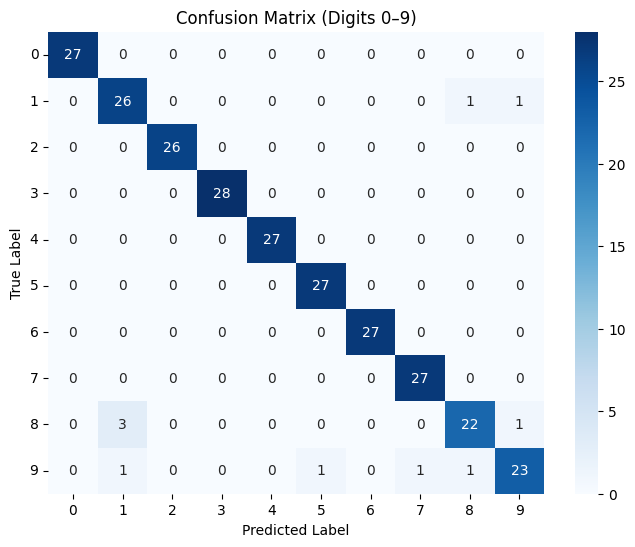

In [11]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")   # color heatmap
plt.title("Confusion Matrix (Digits 0–9)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(10) + 0.5, labels=np.arange(10))
plt.yticks(ticks=np.arange(10) + 0.5, labels=np.arange(10), rotation=0)
plt.show()


Per-Class Metrics

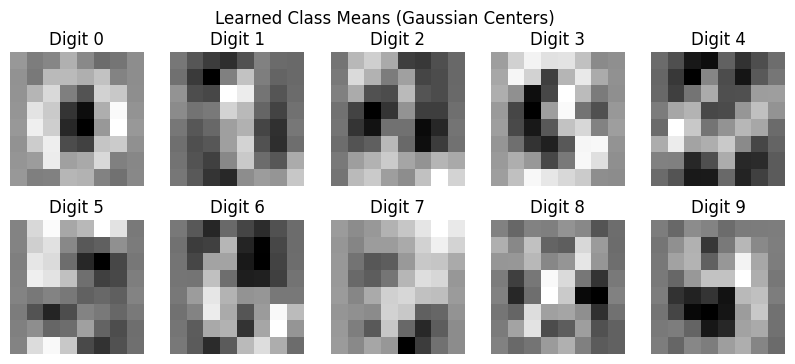

In [12]:
means_images = final_model.means.reshape(-1, 8, 8)
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(means_images[i], cmap="gray")
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.suptitle("Learned Class Means (Gaussian Centers)")
plt.show()

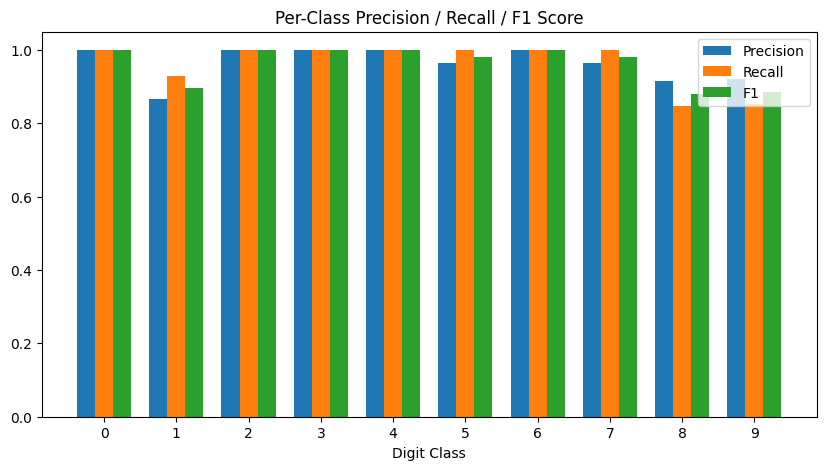

In [13]:
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)

x = np.arange(len(classes))
width = 0.25
plt.figure(figsize=(10,5))
plt.bar(x - width, precision, width=width, label="Precision")
plt.bar(x,        recall, width=width, label="Recall")
plt.bar(x + width, f1, width=width, label="F1")
plt.xticks(x, classes)
plt.xlabel("Digit Class")
plt.title("Per-Class Precision / Recall / F1 Score")
plt.legend()
plt.show()

In [14]:
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      0.93      0.90        28
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        27
           5       0.96      1.00      0.98        27
           6       1.00      1.00      1.00        27
           7       0.96      1.00      0.98        27
           8       0.92      0.85      0.88        26
           9       0.92      0.85      0.88        27

    accuracy                           0.96       270
   macro avg       0.96      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



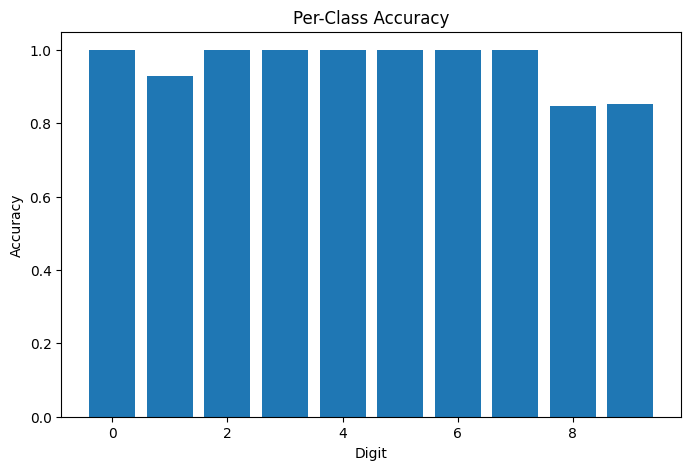

In [15]:
class_acc = np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(8,5))
plt.bar(classes, class_acc)
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()

=== LDA (Shared Covariance Gaussian) ===
Test Accuracy: 0.963
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      0.93      0.90        28
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        27
           5       0.96      1.00      0.98        27
           6       1.00      1.00      1.00        27
           7       0.96      1.00      0.98        27
           8       0.92      0.85      0.88        26
           9       0.92      0.85      0.88        27

    accuracy                           0.96       270
   macro avg       0.96      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



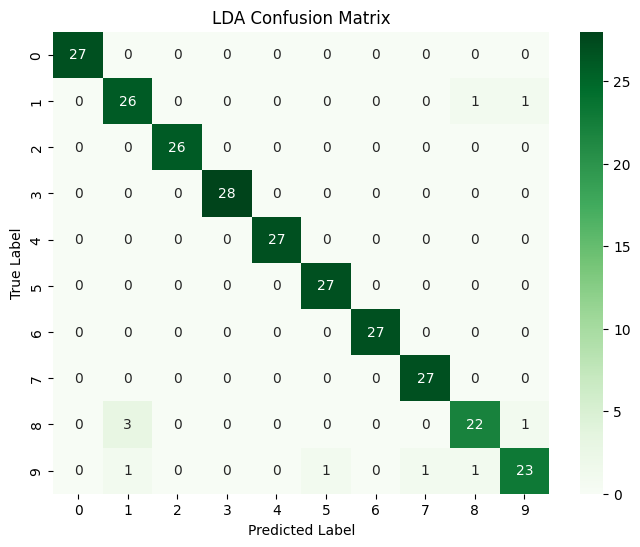

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_final, y_train_final)
y_test_lda = lda.predict(X_test)

print("=== LDA (Shared Covariance Gaussian) ===")
print("Test Accuracy:", round(accuracy_score(y_test, y_test_lda), 4))
print(classification_report(y_test, y_test_lda))

cm_lda = confusion_matrix(y_test, y_test_lda)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lda, annot=True, fmt="d", cmap="Greens")
plt.title("LDA Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [17]:
results = {
    "Model": ["Manual GGC", "LDA (Sklearn)"],
    "Test Accuracy": [
        round(test_accuracy, 4),
        round(accuracy_score(y_test, y_test_lda), 4)
                ]
}

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

           Model  Test Accuracy
0     Manual GGC          0.963
1  LDA (Sklearn)          0.963
